# ADA 2019 – Project Milestone 2
## Evolution of the Music Industry
### Team *Master Yada*:
Jan Waligorski, Jean-Baptiste Membrado, Thomas Petit-Jean, Alexandre Cionca

**Table of Content: [!! TO DO !!]:**
- Data Pre-Processing
    - Discuss kept features, size of dataset, how/why we merged with releases
- Master VS Releases:
    - Number of Master (Albums) per year + discuss
    - Mean number of Releases per Master per year + discuss evolution
- Genres & Labels:
    - Proportion of genres and evolution, discuss link with historical timeline/facts
    - Total number of label per year and evolution, discuss "explosion" of independant artists,etc
    - Number of label per genre (stackplot maybe), again, with evolution
- Format/Support:
    - blablabla
- Discogs Users:
    - Similarities between discogs users, discuss limitations of API (shit), etc

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark import SparkContext

import discogs_client
import os

In [2]:
## Discogs API access for python
# Personnal Discogs API access token
my_token = 'ZgyCYriwcYpJcxCNPHdpDongjdVQkmvOaYzrhzzR'

d = discogs_client.Client('ExampleApplication/0.1', user_token = my_token)

me = d.identity()
print('User logged as {}.'.format(me.username))

Logged as cionkito.


In [ ]:
# Setting up PySpark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.7.0',
                                    ' pyspark-shell'

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','6g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [6]:
discogs_masters = spark.read.format("xml") \
                        .option("rowTag","master") \
                        .load("discogs_20191101_masters.xml.gz")

In [8]:
discogs_masters.printSchema()

root
 |-- _id: long (nullable = true)
 |-- artists: struct (nullable = true)
 |    |-- artist: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- anv: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- join: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- role: string (nullable = true)
 |    |    |    |-- tracks: string (nullable = true)
 |-- data_quality: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- genre: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- images: struct (nullable = true)
 |    |-- image: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |    |    |    |-- _height: long (nullable = true)
 |    |    |    |-- _type: string (nullable = true)
 |    |    |    |-- _uri: string (nullable = true)
 |    |  

In [9]:
discogs_masters.count()

1587241

>**!!Discuss Data and Cleaning!!**, require cleaning and filtering of desired features

## Data Pre-Processing

In [12]:
# Reducing the number of features since some of them seems pretty useless
# and to improve computation time as well.
selected_features = ['_id', 'artists', 'data_quality', 'genres', 'styles', 'title', 'year']

# A first filtering could be to use the "data_quality" feature. It describe if the entry has
# been "validated" by the Discogs administrators. Thus, we will only keep "Correct" entries.

# A second preprocessing step would be to remove all entries with missing years. Since our
# dataset is big enough, it is easier for us (and for later computations) to remove these rows
# instead of filling the missing values. Note that Masters with no publication years 

masters = discogs_masters.select(selected_features)\
                            .filter(discogs_masters.data_quality == "Correct")\
                            .filter(discogs_masters.year > 0)\
                            .dropna(subset = "year")

In [13]:
# Number of total elements after filtering
masters.count()

1485370

In [ ]:
# Storing Master into Pandas
master_DF = masters.toPandas().rename(columns = {'_id':'master_id'})

master_DF.head()

In [ ]:
# Loading of Label and Format list for each master_id (computed on the cluster)
labels = pd.read_json('master_labels_format.json', lines = True)\
            .rename(columns = {'count(id)':'n_releases',
                               'collect_set(format)':'format'})\
            .set_index('master_id')

labels.head()

In [409]:
master_full_DF = master_DF.join(labels, on = 'master_id', how = 'inner')\
                            .drop(columns = ['data_quality'])
master_full_DF.head()

,master_id,artists,genres,main_release,styles,title,year,labels,n_releases,format
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)","([Electronic],)",155102,"([Techno],)",New Soil,2001,[SLS],3,"[CD, Vinyl]"
1,18512,"([(, 212070, , Samuel L Session, , )],)","([Electronic],)",33699,"([Tribal, Techno],)",Psyche EP,2002,[SLS],2,[Vinyl]
2,27800,"([(, 278, , Peshay, , )],)","([Electronic],)",1601455,"([Drum n Bass],)",Renegades Of Funk,2001,[Renegade Recordings],2,[CD]
3,57416,"([(, 3225, , Vince Watson, , )],)","([Electronic],)",1678659,"([Techno],)",Tuff Trax #1 - Basic Functions,1996,[Club Craft],2,[Vinyl]
4,57427,"([(, 3225, , Vince Watson, , )],)","([Electronic],)",828886,"([Techno, Downtempo],)",The eMotion Sequence,2006,[Delsin],2,"[CD, Vinyl]"


In [411]:
# Extracting Genres & Styles out of the RDD rows into lists of strings
master_full_DF.loc[:, 'genres'] = master_full_DF.genres.apply(lambda x: x.genre)

# Some master have "None" Style and thus, we must define a alternate function.
def get_style(row):
    if row is not None:
        return row.style
    else:
        return np.nan

master_full_DF.loc[:, 'styles'] = master_full_DF.styles.apply(get_style)

master_full_DF.head()

,master_id,artists,genres,main_release,styles,title,year,labels,n_releases,format
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)",[Electronic],155102,[Techno],New Soil,2001,[SLS],3,"[CD, Vinyl]"
1,18512,"([(, 212070, , Samuel L Session, , )],)",[Electronic],33699,"[Tribal, Techno]",Psyche EP,2002,[SLS],2,[Vinyl]
2,27800,"([(, 278, , Peshay, , )],)",[Electronic],1601455,[Drum n Bass],Renegades Of Funk,2001,[Renegade Recordings],2,[CD]
3,57416,"([(, 3225, , Vince Watson, , )],)",[Electronic],1678659,[Techno],Tuff Trax #1 - Basic Functions,1996,[Club Craft],2,[Vinyl]
4,57427,"([(, 3225, , Vince Watson, , )],)",[Electronic],828886,"[Techno, Downtempo]",The eMotion Sequence,2006,[Delsin],2,"[CD, Vinyl]"


## Master VS Release
- N masters per year compared with N Releases per year
- Mean number of Releases per master per year

In [415]:
# Counting the number of Master and Releases per year
master_rel_per_year = master_full_DF[['year', 'n_releases']].groupby('year')\
                                                            .agg({'n_releases':['sum','mean'],
                                                                  'year':'count'})
master_rel_per_year

n_releases             year
            sum      mean  count
year                            
1860          2  2.000000      1
1896          5  2.500000      2
1898          4  2.000000      2
1899          3  3.000000      1
1902          7  2.333333      3
...         ...       ...    ...
2015     101262  3.011062  33630
2016     101527  2.985298  34009
2017      92460  2.911667  31755
2018      70401  2.835206  24831
2019        308  2.750000    112

[122 rows x 3 columns]

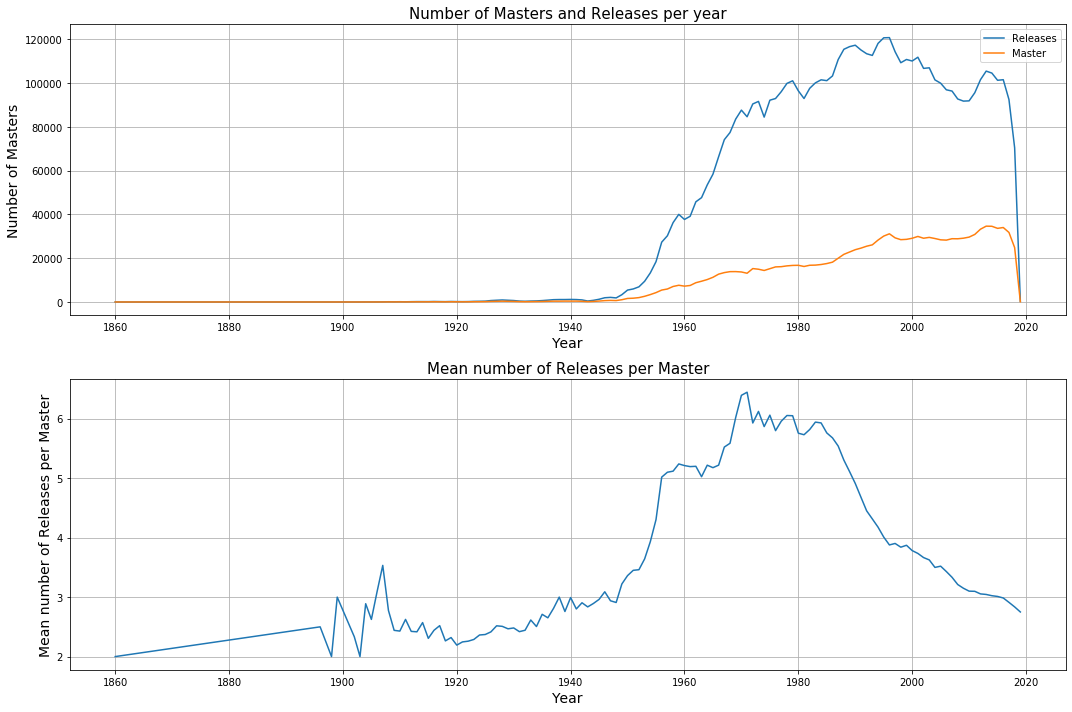

In [432]:
fig, ax = plt.subplots(figsize = (15, 10))

plt.subplot(2,1,1)
plt.title('Number of Masters and Releases per year', fontsize = 15)

plt.plot(master_rel_per_year.n_releases['sum'])
plt.plot(master_rel_per_year.year)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Masters', fontsize = 14)

plt.grid()

plt.legend(['Releases', 'Master'])

plt.subplot(2,1,2)
plt.title('Mean number of Releases per Master', fontsize = 15)

plt.plot(master_rel_per_year.n_releases['mean'])

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Mean number of Releases per Master', fontsize = 14)

plt.grid()
plt.tight_layout()

> **CARE:** Number of Releases may be inaccurate! If a release (re-edition for example) is out 5 years after the master year, it will still count for the **master year** (and not the actual release year). **Maybe describe!**

## Genres & Labels
- Percentage of genres appearance throughout the years, discussion with historical facts
- Number of label per genre (maybe through the years ?), discussions with independent labels

In [54]:
## Number of Masters per year
master_year_genres = masters.groupBy(["year", "genres"]) \
                             .agg(F.count("*").alias("n master"))



,year,genres,n master
0,2011,"([Pop, Folk, World, & Country],)",159
1,2017,"([Non-Music],)",82
2,2006,"([Jazz, Funk / Soul],)",68
3,1996,"([Folk, World, & Country],)",1257
4,1997,"([Reggae],)",520
...,...,...,...
23923,1961,"([Funk / Soul, Stage & Screen],)",1
23924,1971,"([Electronic, Rock, Non-Music, Pop],)",1
23925,1993,"([Hip Hop, Rock, Funk / Soul, Pop],)",1
23926,1996,"([Latin, Pop, Folk, World, & Country, Stage & ...",1


In [132]:
genres_DF = pd.DataFrame(year_genres_DF.explode('genres')\
                         .groupby(['year', 'genres']).sum())\
                        .unstack()['n master'].fillna(0).reset_index()

genres_DF.head(10)

n master
year genres                          
1860 Children's                     1
1896 Jazz                           1
     Pop                            1
1898 Jazz                           1
     Non-Music                      1
1899 Non-Music                      1
1900 Jazz                           1
1901 Non-Music                      1
1902 Classical                      2
     Folk, World, & Country         3

In [315]:
oktamer_1945 = oktamer.loc[oktamer.year < 1945]
oktamer_1945.columns[oktamer_1945.sum(axis = 0) == 0]
oktamer_1945 = oktamer_1945.drop(columns = oktamer_1945\
                                                 .columns[oktamer_1945.sum(axis = 0) == 0])

oktamer_recent = oktamer.loc[oktamer.year >= 1945]
oktamer_recent.columns[oktamer_recent.sum(axis = 0) == 0]
oktamer_recent = oktamer_recent.drop(columns = oktamer_recent\
                                                 .columns[oktamer_recent.sum(axis = 0) == 0])

In [395]:
fig, ax = plt.subplots(figsize = (12, 4))

plt.title('Genre distribution in all Masters')

genres_DF.sum(axis = 0)[1:].plot.bar()

plt.grid(alpha = .4)

TypeError: no numeric data to plot

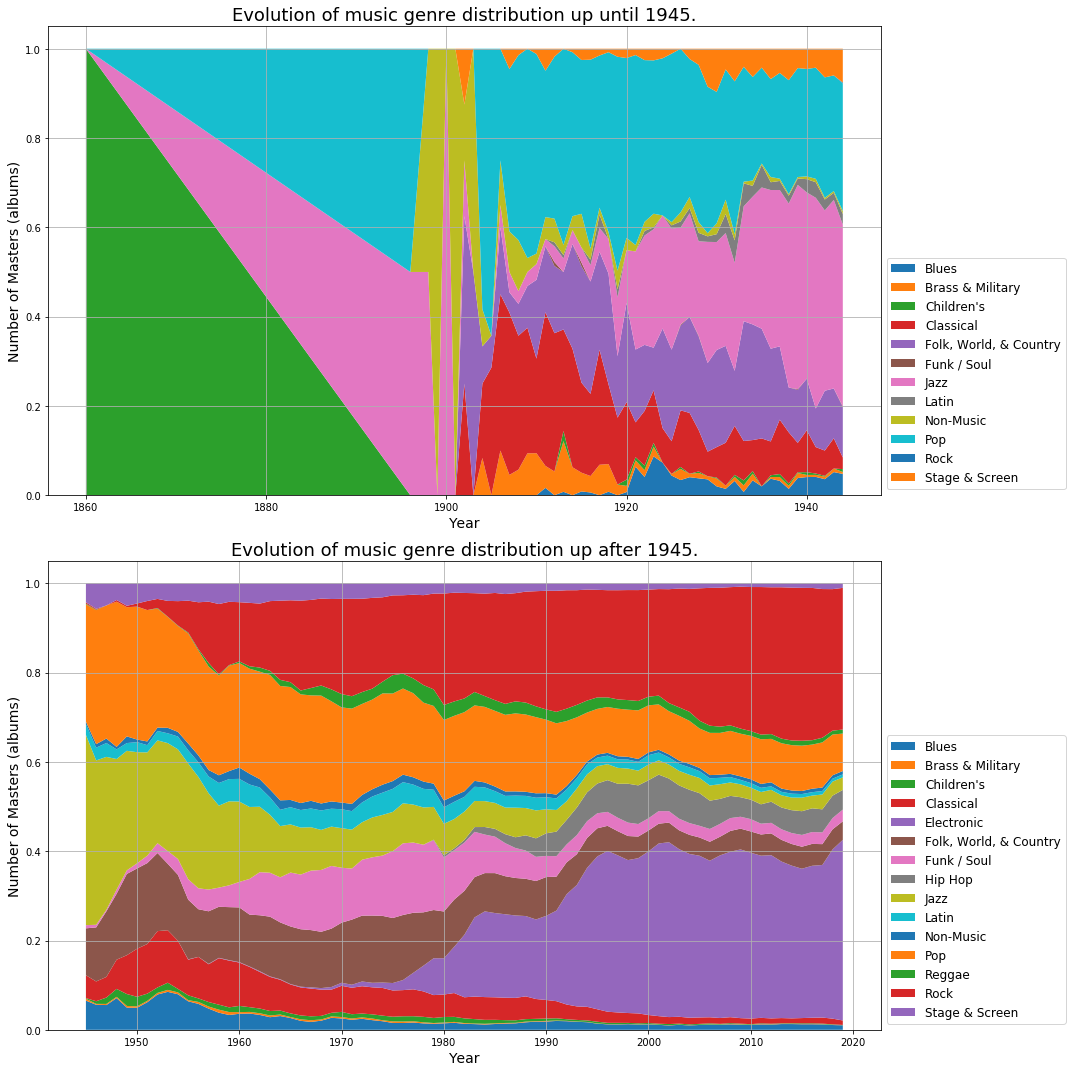

In [354]:
fig, ax = plt.subplots(figsize = (15, 15))

normalize = True

for idx, data in enumerate([oktamer_1945, oktamer_recent]):
    
    plt.subplot(2,1,1 +idx)
    
    if normalize:
        to_plot = data.iloc[:,1:].values.T / data.iloc[:,1:].values.sum(axis = 1)
    else:
        to_plot = data.iloc[:,1:].values.T
    
    if idx == 0:
        plt.title('Evolution of music genre distribution up until 1945.', fontsize = 18)
    else:
        plt.title('Evolution of music genre distribution up after 1945.', fontsize = 18)
     
    plt.stackplot(data.year, to_plot,
                  labels = data.columns.values[1:],
                  cmap = "Greens")
    
    plt.xlabel('Year', fontsize = 14)
    plt.ylabel('Number of Masters (albums)', fontsize = 14)
    
    plt.grid()
    plt.legend(loc = 'lower left', ncol = 1, fontsize = 12, bbox_to_anchor=(1, 0))
    
plt.tight_layout()

## Music support
- Number of support as a fct of time
- Percentage of support "usage" through time
    - Discuss all links with new technologies, streaming, etc
- **!!MAYBE!!** Vinyl VS CD, can we highlight the *"ReHyping"* of vinyl these years ?

## Discogs Social Media (with API SHIT)
- Courage, force et honneur

In [392]:
def get_label(master_id):
    
    labels = []
    
    for rel in d.master(master_id).versions:
        for lab in rel.labels:
            labels.append(lab.name)
            
    return labels

get_lab = F.udf(lambda master_id: get_label(master_id))

get_label(12345)

['Impact Records (23)', 'Impact Records (23)', 'Impact Records (23)']

In [295]:
jsp = d.master(1234)

for ver in jsp.versions:
    print(ver.labels)

[<Label 461 'Neue Heimat'>]
[<Label 461 'Neue Heimat'>]
[<Label 461 'Neue Heimat'>]


In [109]:
fdp = masters.take(1)[0]
get_label(fdp._id)

['SLS', 'SLS', 'SLS']